In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import time
import sqlite3
import matplotlib.pyplot as plt

In [2]:
def epoch_timestring(epoch_time):
    return time.strftime('%H:%M:%S', time.localtime(int(epoch_time))) #%d%B%YT%H:%M:%S

def date_epoch(date_string):
    utc_time = dt.strptime(date_string, "%Y-%m-%d")
    epoch_start_time = utc_time.timestamp()
    return epoch_start_time + 900, epoch_start_time + 86400

In [3]:
def downsample(data, factor):
    np_data = np.asarray(data)
    np_sliced = np_data[::factor]

    return np_sliced

In [23]:
def daily_flow(date_string, source, downsample_factor = 1):
    conn = sqlite3.connect('/home/sohamp/project_course_sem6/git/Dash Server/water_data.db')
    cursor = conn.cursor()

    if date_string == 'all':
        start_epoch, end_epoch = 0, 2000000000#date_epoch(date_string)
    else:
        start_epoch, end_epoch = date_epoch(date_string)
    time_list, daily_flow = None, None
    
    if source == 'CWPS':
        cursor.execute(
            'SELECT timeEpoch, daily_Flow, Daily_Flow, Wet_Well_Level FROM cwps WHERE timeEpoch>{} AND timeEpoch<{}'
                        .format(start_epoch, end_epoch))
        np_ = np.asarray(cursor.fetchall())
        level_ = np_[:,3]
        time_list = list(map(epoch_timestring, list(np_[:, 0])))

    elif source == 'WSC_FW':
        cursor.execute(
            'SELECT timeEpoch, daily_flow, daily_flow, ult FROM wsc1_fwp WHERE timeEpoch>{} AND timeEpoch<{}'
                        .format(start_epoch, end_epoch))
        np_ = np.asarray(cursor.fetchall())
        level_ = np_[:,3]
        time_list = list(map(epoch_timestring, list(np_[:, 0])))

    elif source == 'WSC_RW':
        cursor.execute(
            'SELECT timeEpoch, daily_flow, daily_flow, ult FROM wsc1_rwp WHERE timeEpoch>{} AND timeEpoch<{}'
                        .format(start_epoch, end_epoch))
        np_ = np.asarray(cursor.fetchall())
        level_ = np_[:,3]
        # reason for multiplication by 4: The recycled water flows are lesser than that for fresh and cwps water
        # To measure changes in slope, this amplification makes task easier
        time_list = list(map(epoch_timestring, list(np_[:, 0])))
    
    else:
        print("Incoorrect source, enter CWPS, WSC_FW, WSC_RW")
        return -1
    
    return np_, np.asarray(time_list)

In [24]:
dict_day = {}
for dd, day in zip(range(3,9),['Sun','Mon','Tue', 'Wed', 'Thu', 'Fri']):
    d_string = '2019-03-0{}'.format(dd)
    dict_day[d_string]=day

In [26]:
np_, t = daily_flow('2019-03-04', 'WSC_FW', 1)

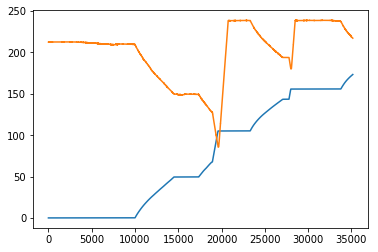

In [31]:
plt.plot(np_[:,2])
plt.plot(np_[:,3]*50)

In [10]:
lt = {'CWPS':[],'WSC_FW':[],'WSC_RW':[]}
for dd in range(3,9):
    d_string = '2019-03-0{}'.format(dd)
    for source in ['CWPS', 'WSC_FW', 'WSC_RW']:
        cwps, t = daily_flow(d_string, source, 1)
    #     wsc_fw, t = daily_flow(d_string, 'WSC_FW', 1)
    #     wsc_rw, t= daily_flow(d_string, 'WSC_RW', 1)
        lt[source].append([dict_day[d_string], source, cwps[-1]])

In [8]:
# pd.DataFrame(lt['WSC_RW'],columns=['Date','Source','Water Consumption']).to_csv('WSC_RW')

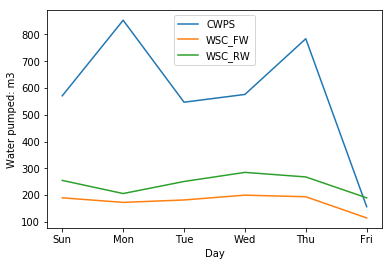

In [17]:
for source in ['CWPS', 'WSC_FW', 'WSC_RW']:
#     plt.cla()   # Clear axis
#     plt.clf()   # Clear figure
#     plt.close() # Close a figure window
    time_ = np.asarray(lt[source])[:,0]
    daily = np.asarray(lt[source])[:,2].astype('float')
    plt.xlabel('Day')
    plt.ylabel('Water pumped: m3')
#     plt.title('{} Consumption'.format(source))
    plt.plot(time_,daily, label=source)
    plt.legend()
plt.savefig('{}.jpg'.format('water_consumption'))
